## Loading Data

In [1]:
path = 'dataset_commands'

In [2]:
import tensorflow as tf
import pathlib
import numpy as np

2024-09-25 17:19:05.899178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 17:19:05.951561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 17:19:05.966066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 17:19:06.064823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 17:19:07.085455: W tensorflow/compiler/tf2

In [3]:
def read_files(path):
    data_dir = pathlib.Path(path)

    all_audio_paths = list(data_dir.glob('*/**/*.wav'))
    all_labels = [path.parent.name for path in all_audio_paths]

    # converting paths to strings
    all_audio_paths = [str(path) for path in all_audio_paths]

    return all_audio_paths, all_labels

In [4]:
all_audio_paths, all_labels = read_files(path)

## Understanding the data

All labels:

In [5]:
np.unique(all_labels)

array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

Number of labels:

In [6]:
np.unique(all_labels).shape

(36,)

### Visualizing an audio

2024-09-25 17:19:10.977783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


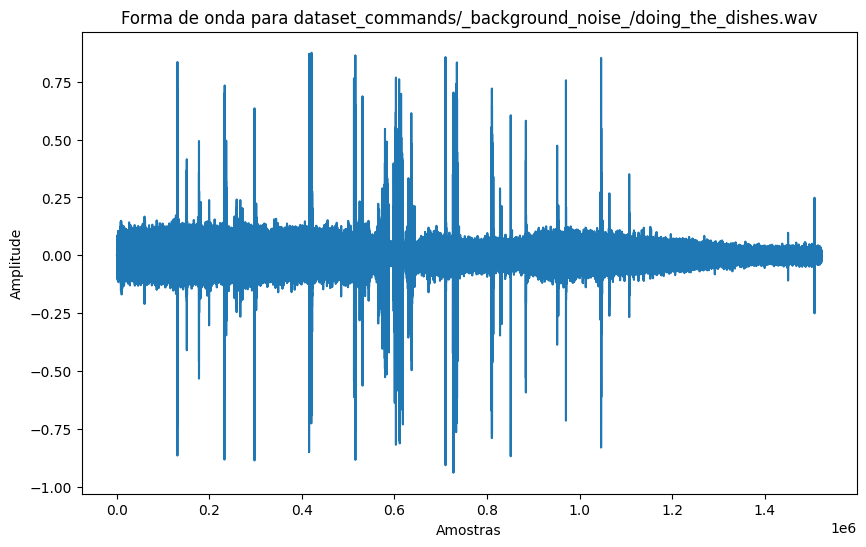

In [7]:
import matplotlib.pyplot as plt

# Reading one example of audio
example_audio_path = all_audio_paths[0]
audio_binary = tf.io.read_file(example_audio_path)
audio, _ = tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=-1)

# Ploting the audio
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()


## Preprocessing

In [8]:
from scipy.signal import resample

In [9]:
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav
    
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT')
        
    return tf.reshape(wav, [max_length])

In [10]:
def process_path(file_path, label):
    audio = load_and_process_audio(file_path)
    return audio, label

In [11]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    audio_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return audio_label_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

In [14]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_audio_paths, all_labels_encoded, test_size=0.02, random_state=42, stratify=all_labels_encoded)

In [15]:
train_dataset = paths_and_labels_to_dataset(train_paths, train_labels)
val_dataset = paths_and_labels_to_dataset (val_paths, val_labels)

In [16]:
train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

## Training the model

In [17]:
from tensorflow.keras import layers, models

In [18]:
model_time_domain = models.Sequential([
    layers.Input(shape=(16000, 1)),
    layers.Conv1D(16, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(36, activation='softmax')
])

In [19]:
model_time_domain.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [20]:
history_time_domain = model_time_domain.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


I0000 00:00:1727284811.754580    2382 service.cc:146] XLA service 0x7fcda00040c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727284811.754775    2382 service.cc:154]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-09-25 17:20:11.793958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-25 17:20:11.929685: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


   3/3242 ━━━━━━━━━━━━━━━━━━━━ 2:20 43ms/step - accuracy: 0.0035 - loss: 3.6221     

I0000 00:00:1727284813.989256    2382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3242/3242 ━━━━━━━━━━━━━━━━━━━━ 363s 109ms/step - accuracy: 0.1314 - loss: 3.1633 - val_accuracy: 0.2518 - val_loss: 2.6646
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 71s 21ms/step - accuracy: 0.2832 - loss: 2.5052 - val_accuracy: 0.2933 - val_loss: 2.5246
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - accuracy: 0.3517 - loss: 2.2290 - val_accuracy: 0.3070 - val_loss: 2.5521
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - accuracy: 0.4102 - loss: 2.0021 - val_accuracy: 0.2976 - val_loss: 2.6446
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - accuracy: 0.4666 - loss: 1.7980 - val_accuracy: 0.3089 - val_loss: 2.7549
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 61s 19ms/step - accuracy: 0.5188 - loss: 1.6151 - val_accuracy: 0.3226 - val_loss: 2.9143
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step - accuracy: 0.5703 - loss: 1.4432 - val_accuracy: 0.3222 - val_loss: 3.0918
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.6136 - loss: 1.

In [21]:
def plot_history(history):
    # Resumo do histórico de precisão
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')

    # Resumo do histórico de perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

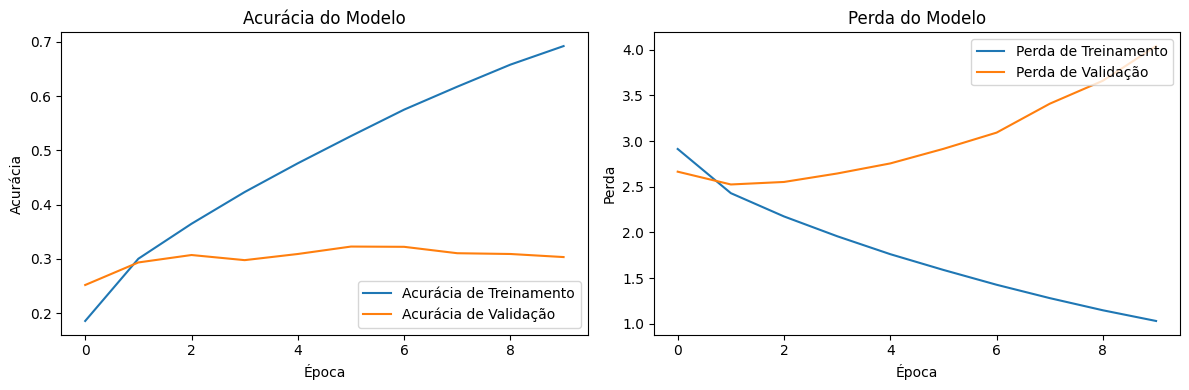

In [22]:
plot_history(history_time_domain)

## Transforming to Frequency Domain

In [89]:
def spectrogram(wave_form):
    spect = tf.signal.stft(wave_form, frame_length=255, frame_step=128)
    spect = tf.abs(spect)
    spect = spect[..., tf.newaxis]
    return spect

In [90]:
spect = spectrogram(audio)

In [91]:
def plot_spectrogram(spectrogram):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

        log_spec = np.log(spectrogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]

        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.pcolormesh(X, Y, log_spec)

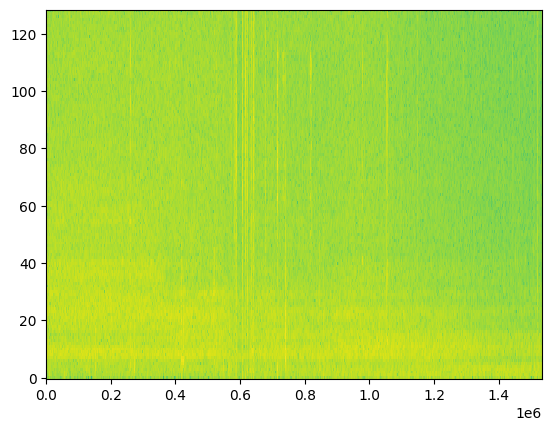

In [92]:
plot_spectrogram(spect)

In [35]:
def get_spectrogram_and_label_id(audio, label):
    spect = spectrogram(audio)
    return spect, label

In [37]:
train_spec = train_dataset.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
val_spec = val_dataset.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)

### Normalization

In [56]:
norm_layer = tf.keras.layers.Normalization()

for spectrogram, _ in train_spec.take(1):
    norm_layer.adapt(spectrogram)
    input_shape = spectrogram.shape[1:]

In [57]:
input_shape

TensorShape([124, 129, 1])

In [39]:
num_labels = len(np.unique(all_labels))

## Training the neural network

In [58]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

In [59]:
model_spectrogram.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [60]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=val_spec)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.3341 - loss: 2.3829 - val_accuracy: 0.7388 - val_loss: 0.9329
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.6407 - loss: 1.2115 - val_accuracy: 0.7874 - val_loss: 0.7450
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7004 - loss: 1.0131 - val_accuracy: 0.8101 - val_loss: 0.6501
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7305 - loss: 0.8927 - val_accuracy: 0.8224 - val_loss: 0.6092
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7496 - loss: 0.8266 - val_accuracy: 0.8304 - val_loss: 0.5825
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7670 - loss: 0.7694 - val_accuracy: 0.8266 - val_loss: 0.5680
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7758 - loss: 0.7340 - val_accuracy: 0.8389 - val_loss: 0.5624
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7869 - loss:

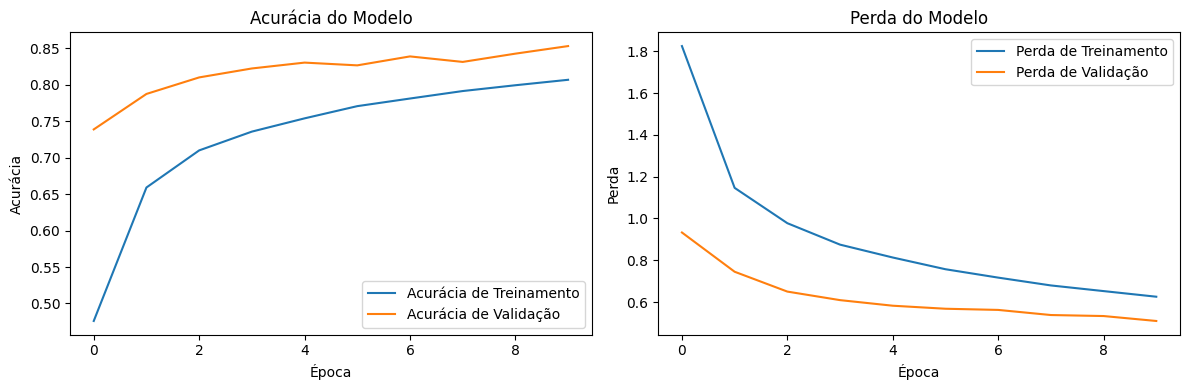

In [63]:
plot_history(history_spectrogram)

## Using Channel Attention

In [69]:
@tf.keras.utils.register_keras_serializable()
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

    def build(self, input_shape):
        self.fc1 = layers.Dense(units=input_shape[-1] // self.ratio, activation='relu')
        self.fc2 = layers.Dense(units=input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        avg_out = self.fc2(self.fc1(avg_out))
        max_out = self.fc2(self.fc1(max_out))
        out = avg_out + max_out
        out = tf.expand_dims(tf.expand_dims(out, axis=1), axis=1)
        return inputs * out

In [70]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.Conv2D(64, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

In [71]:
model_spectrogram.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=val_spec)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.3381 - loss: 2.3352 - val_accuracy: 0.7572 - val_loss: 0.8777
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.6485 - loss: 1.1745 - val_accuracy: 0.8016 - val_loss: 0.6684
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7082 - loss: 0.9735 - val_accuracy: 0.8257 - val_loss: 0.6023
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7372 - loss: 0.8670 - val_accuracy: 0.8385 - val_loss: 0.5685
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7569 - loss: 0.7959 - val_accuracy: 0.8503 - val_loss: 0.5220
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7759 - loss: 0.7286 - val_accuracy: 0.8474 - val_loss: 0.4911
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7884 - loss: 0.6906 - val_accuracy: 0.8602 - val_loss: 0.4706
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7994 - loss:

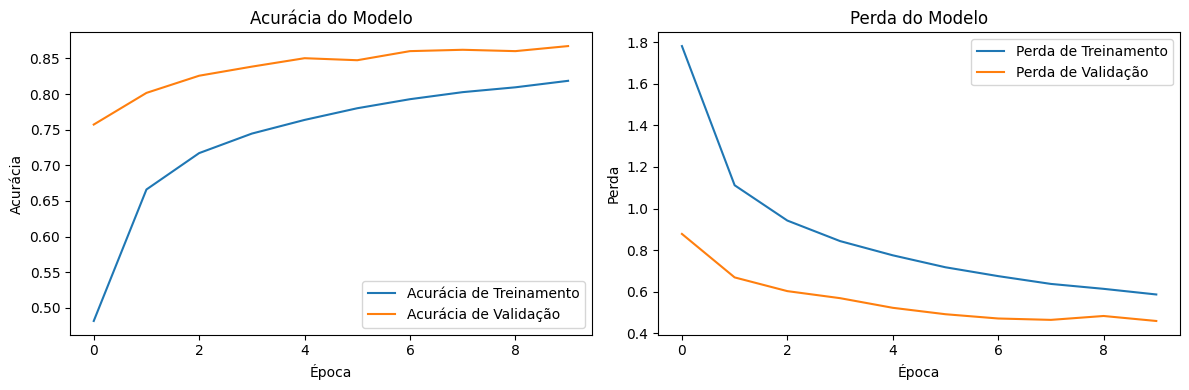

In [73]:
plot_history(history_spectrogram)

## Predictions

In [96]:
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav
    
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT')
        
    return tf.reshape(wav, [max_length])

In [97]:
def spectrogram(wave_form):
    spect = tf.signal.stft(wave_form, frame_length=255, frame_step=128)
    spect = tf.abs(spect)
    spect = spect[..., tf.newaxis]
    return spect

In [102]:
specific_audio_path = 'yes.wav'
specific_audio = load_and_process_audio(specific_audio_path)
specific_spectrogram = spectrogram(specific_audio)
specific_spectrogram_batch = np.expand_dims(specific_spectrogram, axis=0)
specific_prediction = model_spectrogram.predict(specific_spectrogram_batch)
specific_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[1.00332970e-42, 5.20358938e-23, 8.31169682e-12, 3.43937364e-17,
        1.56734600e-07, 1.51218244e-17, 3.80276512e-13, 4.87049474e-13,
        2.18000891e-19, 3.09896210e-26, 2.57468137e-27, 7.50196516e-19,
        1.62480858e-14, 1.02616659e-13, 2.50782861e-09, 9.61195915e-11,
        2.66541935e-08, 6.05656284e-17, 5.51894322e-16, 5.22006882e-09,
        1.06671306e-16, 4.76927061e-25, 5.39205789e-18, 7.48542921e-15,
        2.53530796e-18, 2.85753257e-12, 5.56348689e-10, 1.53517338e-20,
        6.77296313e-19, 7.72004354e-21, 2.44417233e-16, 1.09271218e-19,
        1.76928752e-12, 4.00537363e-17, 9.99999762e-01, 3.59401670e-14]],
      dtype=float32)

In [105]:
specific_predicted_label = np.argmax(specific_predictions, axis=-1)[0]
label_encoder.inverse_transform([specific_predicted_label])[0]

'yes'

In [106]:
model_spectrogram.save("model_spectrogram.keras")